# Bone Fracture Classifier
This is a Deep Learning Course project for classifying x-ray bone images if thay have fracture on the bone or not. The images are from different parts of human body.

The dataset used can be found in the following link: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data

Python version: 3.12.4

python packages needed: torch torchvision torchaudio torchmetrics matplotlib


### 1. Importing necessary libraries

In [18]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics import Accuracy
import torch
from PIL import ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = "cuda" if torch.cuda.is_available() else "cpu"

### 2. Buiding the model

In [ ]:
# The model Layers is inspired by Nirmal Gaud: https://www.kaggle.com/code/nirmalgaud/bone-fracture-detection-97-accuracy-cnn
class FractureDetector(nn.Module):
    def __init__(self):
        super(FractureDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3)
        self.maxpooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(86528, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

        
    def forward(self, x):
        x = self.maxpooling(self.relu(self.conv1(x)))
        x = self.maxpooling(self.relu(self.conv2(x)))
        x = self.maxpooling(self.relu(self.conv3(x)))
        x = self.classifier(x)

        return x

### 3. Training the model

In [ ]:
batch_size = 32
lr = 0.001
epochs = 20

# Data preperation
# transforms.Resize is from chatgpt
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train = datasets.ImageFolder("./Bone_Fracture_Binary_Classification/train", transform=transform)
test = datasets.ImageFolder("./Bone_Fracture_Binary_Classification/test", transform=transform)
validation = datasets.ImageFolder("./Bone_Fracture_Binary_Classification/val", transform=transform)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size)
validation_loader = DataLoader(validation, batch_size=batch_size)


model = FractureDetector().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
acc = Accuracy(task="binary").to(device)
test_acc = Accuracy(task="binary").to(device)
val_acc = Accuracy(task="binary").to(device)
history = {"Epochs": [], "Train_loss": [], "Train_accuracy": [], "Test_accuracies": []}

def train():
    for epoch in range(epochs):
        total_loss = 0
        history["Epochs"].append(epoch)

        model.train()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()

            # Loss calculation is from chatgpt
            outputs = model(images).squeeze(1)
            loss = loss_fn(outputs, labels)
            acc.update(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
        
        total_loss = total_loss / len(train_loader)
        epoch_acc = acc.compute().item()
        acc.reset()

        history["Train_loss"].append(total_loss)
        history["Train_accuracy"].append(epoch_acc)

        # Changing to evaluation mode to calcualte the test accuracy
        model.eval()
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images).squeeze(1)
            test_acc.update(outputs, labels)

        t_acc = test_acc.compute().item()
        test_acc.reset()
        history["Test_accuracies"].append(t_acc)

        print(f"Epoch Number {epoch + 1} | Loss {total_loss:.6f} | Train Accuracy {epoch_acc:.4f} | Test Accuracy {t_acc:.4f}")
    
    # Changing to evaluation mode to calculate the validation accuracy
    model.eval()
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images).squeeze(1)
        val_acc.update(outputs, labels)


    print(f"Validation Accuracy: {val_acc.compute().item():.4f}")

    print("Saving the model...")
    torch.save(model.state_dict(), "./FractureClassifier.pt")
    print("The model is saved.")


In [ ]:
# Start training the model
train()

Epoch Number 1 | Loss 0.419875 | Train Accuracy 0.7685 | Test Accuracy 0.9012
Epoch Number 2 | Loss 0.050605 | Train Accuracy 0.9845 | Test Accuracy 0.9822
Epoch Number 3 | Loss 0.012923 | Train Accuracy 0.9951 | Test Accuracy 0.9980
Epoch Number 4 | Loss 0.013490 | Train Accuracy 0.9960 | Test Accuracy 0.9941
Epoch Number 5 | Loss 0.003560 | Train Accuracy 0.9985 | Test Accuracy 0.9960
Epoch Number 6 | Loss 0.021220 | Train Accuracy 0.9931 | Test Accuracy 0.9743
Epoch Number 7 | Loss 0.007056 | Train Accuracy 0.9974 | Test Accuracy 0.9960
Epoch Number 8 | Loss 0.010415 | Train Accuracy 0.9977 | Test Accuracy 0.9506
Epoch Number 9 | Loss 0.013309 | Train Accuracy 0.9952 | Test Accuracy 0.9960
Epoch Number 10 | Loss 0.002685 | Train Accuracy 0.9991 | Test Accuracy 1.0000
Epoch Number 11 | Loss 0.003332 | Train Accuracy 0.9990 | Test Accuracy 1.0000
Epoch Number 12 | Loss 0.000568 | Train Accuracy 0.9999 | Test Accuracy 1.0000
Epoch Number 13 | Loss 0.002700 | Train Accuracy 0.9995 | Tes

d:\Documents\Prog\Python\venv\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 0.9855
Saving the model...
The model is saved.


### 4. Results Visualization

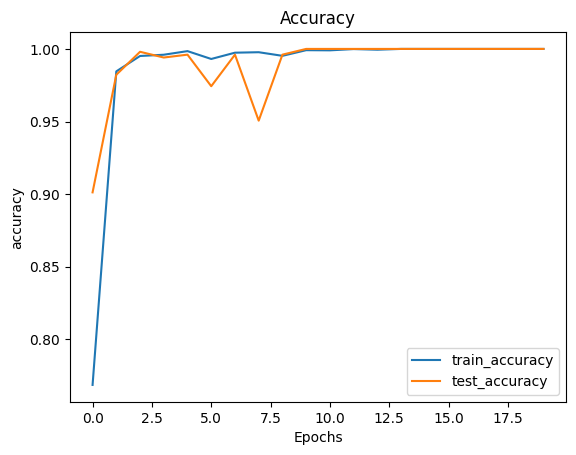

In [29]:
plt.plot(history["Epochs"], history["Train_accuracy"], label="train_accuracy")
plt.plot(history["Epochs"], history["Test_accuracies"], label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()


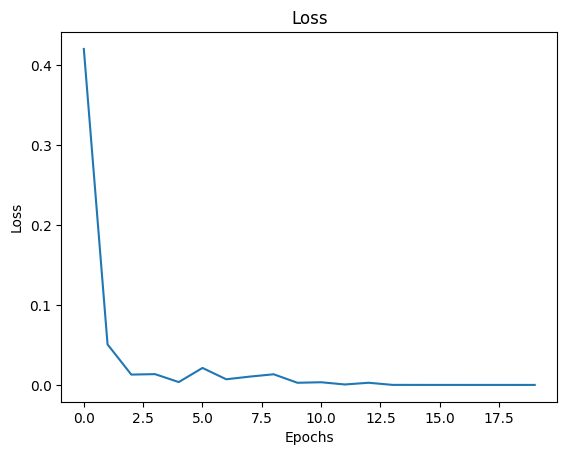

In [30]:
plt.plot(history["Epochs"], history["Train_loss"])
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()